In [3]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
import csv
%matplotlib inline

### Load and format data

In [4]:
files = glob('./july/*.txt')
data = []
for file in files:
    with open(file,'rt') as f:
        reader = csv.reader((line.replace('\0','') for line in f),delimiter = ',', quotechar = '"')
        data += [row for row in reader]

['./turnstile_130706.txt',
 './turnstile_130713.txt',
 './turnstile_130720.txt',
 './turnstile_130727.txt',
 './turnstile_130803.txt']

In [34]:
locs = {}
for d in data:
    location = d[0]+' '+d[1]+' '+d[2]
    if location not in locs:
        locs[location] = d[3:]
    for n in d[3:]:
        locs[location].append(n)

In [38]:
df = pd.DataFrame()
for loc in list(locs.keys()):
    d = pd.DataFrame(np.array(locs[loc]).reshape(-1,5),columns = ['date','time','disc','entries','exits'])
    d['location'] = loc
    d = d.drop_duplicates()
    d[['entries','exits']] = d[['entries','exits']].apply(pd.to_numeric)
    d['datetime'] = d['date']+' '+d['time']
    f = '%m-%d-%y %H:%M:%S'
    d['dt'] = d['datetime'].apply(lambda x: datetime.strptime(x,f))
    d=d.sort_values(by = 'datetime')
    d['entries_change'] = d['entries'].diff(+1)
    d['exits_change'] = d['exits'].diff(+1)
    df=df.append(d)

In [1]:
#Save file
#df.to_csv('july_data.csv', index = False)

In [282]:
df = pd.read_csv('july_data.csv')
df.head()

,date,time,disc,entries,exits,location,datetime,dt,entries_change,exits_change
0,06-29-13,00:00:00,REGULAR,3775585,4786056,C008 R099 00-00-00,06-29-13 00:00:00,2013-06-29 00:00:00,NaN,NaN
1,06-29-13,04:00:00,REGULAR,3775645,4786184,C008 R099 00-00-00,06-29-13 04:00:00,2013-06-29 04:00:00,60.0,128.0
2,06-29-13,04:00:00,RECOVR AUD,3775645,4786184,C008 R099 00-00-00,06-29-13 04:00:00,2013-06-29 04:00:00,0.0,0.0
3,06-29-13,08:00:00,REGULAR,3775689,4786264,C008 R099 00-00-00,06-29-13 08:00:00,2013-06-29 08:00:00,44.0,80.0
4,06-29-13,09:15:50,DOOR OPEN,3775722,4786301,C008 R099 00-00-00,06-29-13 09:15:50,2013-06-29 09:15:50,33.0,37.0


#### Merge with Station codes

In [182]:
#add station info
df['Booth'] = df['location'].apply(lambda x : x.split(' ')[0])
df['Remote'] = df['location'].apply(lambda x:x.split(' ')[1])
code_map = pd.read_csv('Remote-Booth-Station.csv')
df_merge = pd.merge(df,code_map,on = ['Remote','Booth'])
df_merge.head()

,date,time,disc,entries,exits,location,datetime,dt,entries_change,exits_change,Booth,Remote,Station,Line Name,Division
0,06-29-13,00:00:00,REGULAR,3775585,4786056,C008 R099 00-00-00,06-29-13 00:00:00,2013-06-29 00:00:00,NaN,NaN,C008,R099,DEKALB AVE,BDNQR,BMT
1,06-29-13,04:00:00,REGULAR,3775645,4786184,C008 R099 00-00-00,06-29-13 04:00:00,2013-06-29 04:00:00,60.0,128.0,C008,R099,DEKALB AVE,BDNQR,BMT
2,06-29-13,04:00:00,RECOVR AUD,3775645,4786184,C008 R099 00-00-00,06-29-13 04:00:00,2013-06-29 04:00:00,0.0,0.0,C008,R099,DEKALB AVE,BDNQR,BMT
3,06-29-13,08:00:00,REGULAR,3775689,4786264,C008 R099 00-00-00,06-29-13 08:00:00,2013-06-29 08:00:00,44.0,80.0,C008,R099,DEKALB AVE,BDNQR,BMT
4,06-29-13,09:15:50,DOOR OPEN,3775722,4786301,C008 R099 00-00-00,06-29-13 09:15:50,2013-06-29 09:15:50,33.0,37.0,C008,R099,DEKALB AVE,BDNQR,BMT


In [103]:
#Save
#df_merge.to_csv('july_data_station.csv',index=False)

In [4]:
#calculate whole system entries/exits at each time point
df_merge = pd.read_csv('july_data_station.csv')
df_change = df_merge.groupby('dt').sum().reset_index()
df_change.head()

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,dt,entries,exits,entries_change,exits_change,busyness
0,2013-06-29 00:00:00,14055198997,7474963985,0.0,0.0,0.0
1,2013-06-29 00:00:39,819,16429,NaN,NaN,NaN
2,2013-06-29 00:01:02,53737,98766,NaN,NaN,NaN
3,2013-06-29 00:01:44,150350,265233,NaN,NaN,NaN
4,2013-06-29 00:01:55,65330,154888,NaN,NaN,NaN


## DATA exploration by PLOT  

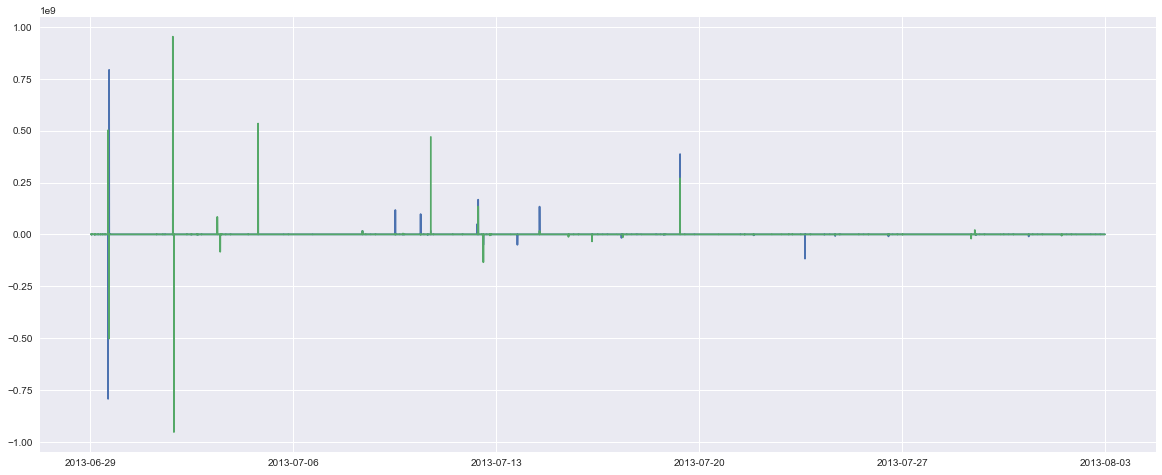

In [184]:
#plot data for the month
date_time = matplotlib.dates.datestr2num(df_change['dt'].tolist())
plt.figure(figsize = (20,8))
plt.plot_date(date_time,df_change['entries_change'],'-')
plt.plot_date(date_time,df_change['exits_change'],'-')
#plt.plot_date(date_time,df_change['busyness'],'-')

#### Replace negative values with 0
It's not possible to have negative counts, negative value means the odometer got reset.
sometimes the odometer also jumps randomly, giving a huge reading.Based on the average ridership below from 2015, counts higher than 1.2M and lower than 0 will be take out.

Ridership: In 2015, average weekday subway ridership was 5.7 million, the highest since 1948. Annual ridership was 1.763 billion, also the highest since 1948.(wiki)


In [190]:
#remove outlier
df_change.loc[df_change[df_change['entries_change']<0].index,'entries_change']=0
df_change.loc[df_change[df_change['exits_change']<0].index,'exits_change'] = 0
#df_change.loc[df_change[df_change['busyness']<0].index,'busyness'] = 0
df_change.loc[df_change[df_change['entries_change']>1200000].index,'entries_change']=0
df_change.loc[df_change[df_change['exits_change']>1200000].index,'exits_change'] = 0
#df_change.loc[df_change[df_change['busyness']>4000000].index,'busyness'] = 0

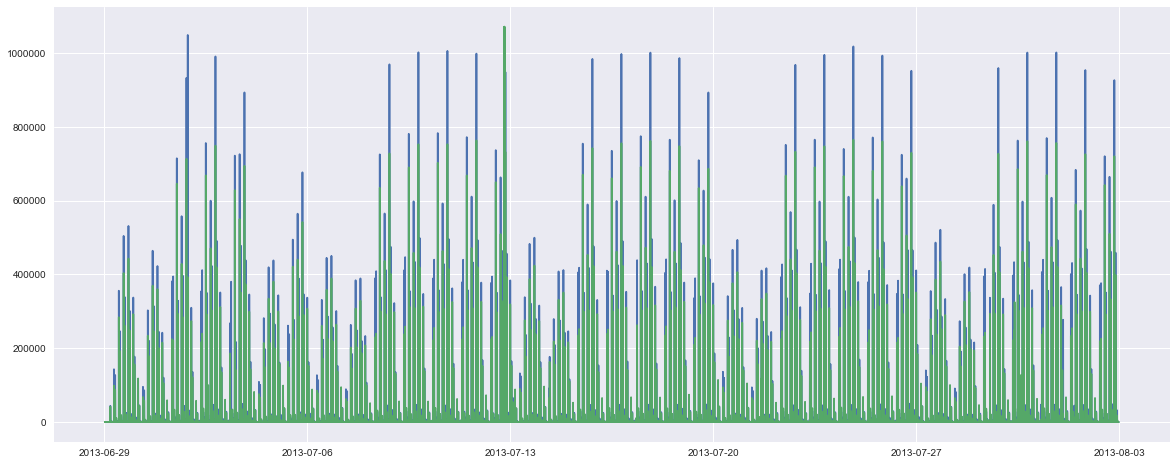

In [192]:
#plot again with outliers removed
date_time = matplotlib.dates.datestr2num(df_change['dt'].tolist())
plt.figure(figsize = (20,8))
plt.plot_date(date_time,df_change['entries_change'],'-')
plt.plot_date(date_time,df_change['exits_change'],'-')
#plt.plot_date(date_time,df_change['busyness'],'-')

nice periodic pattern!


### PLOT Only regular data

In [193]:
df_regular = df_merge[df_merge['disc'] == 'REGULAR']
df_regular.shape

(946417, 15)

In [194]:
df_re_change = df_regular.groupby('dt').sum().reset_index()
df_re_change.head()

,dt,entries,exits,entries_change,exits_change
0,2013-06-29 00:00:00,13838089395,7392609980,0.0,0.0
1,2013-06-29 00:00:39,819,16429,NaN,NaN
2,2013-06-29 00:01:02,53737,98766,NaN,NaN
3,2013-06-29 00:01:44,150350,265233,NaN,NaN
4,2013-06-29 00:01:55,65330,154888,NaN,NaN


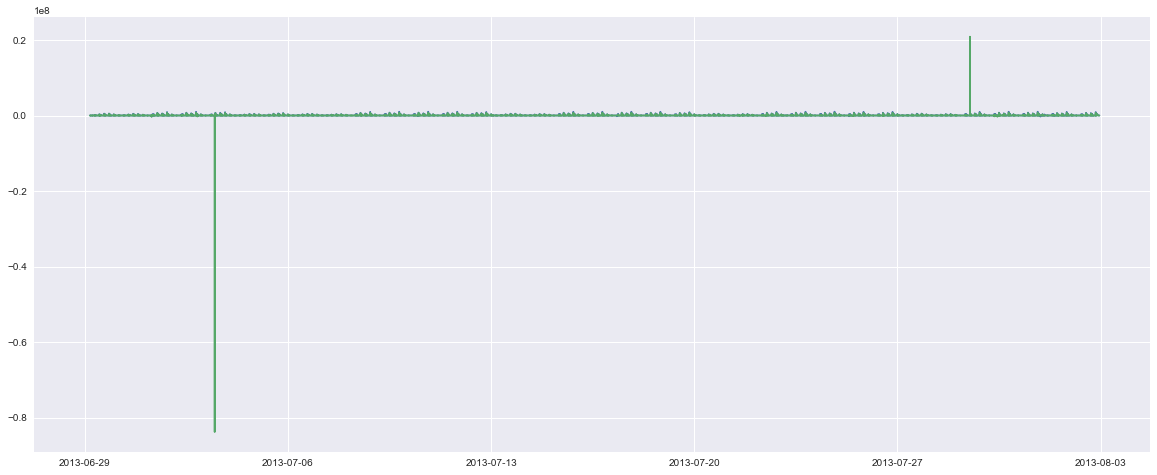

In [195]:
date_time = matplotlib.dates.datestr2num(df_re_change['dt'].tolist())
plt.figure(figsize = (20,8))
plt.plot_date(date_time,df_re_change['entries_change'],'-')
plt.plot_date(date_time,df_re_change['exits_change'],'-')
#plt.plot_date(date_time,df_re_change['busyness'],'-')

In [197]:
#remove outlier
df_re_change.fillna(0)
df_re_change.loc[df_re_change[df_re_change['entries_change']<0].index,'entries_change']=0
df_re_change.loc[df_re_change[df_re_change['exits_change']<0].index,'exits_change'] = 0
df_re_change.loc[df_re_change[df_re_change['entries_change']>2000000].index,'entries_change']=0
df_re_change.loc[df_re_change[df_re_change['exits_change']>2000000].index,'exits_change'] = 0
#df_re_change.loc[df_re_change[df_re_change['busyness']<0].index,'busyness'] = 0
#df_re_change.loc[df_re_change[df_re_change['busyness']>2000000].index,'busyness'] = 0

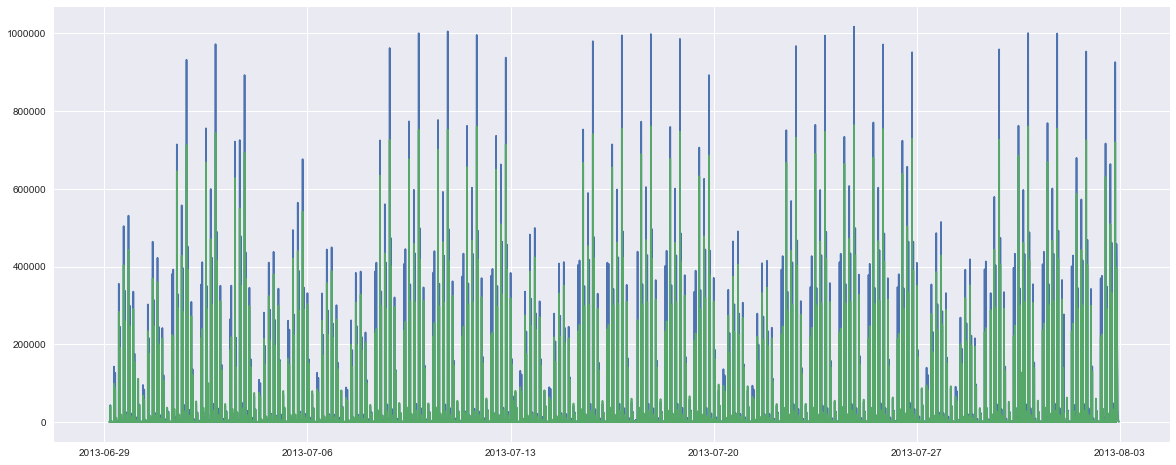

In [198]:
date_time = matplotlib.dates.datestr2num(df_re_change['dt'].tolist())
plt.figure(figsize = (20,8))
plt.plot_date(date_time,df_re_change['entries_change'],'-')
plt.plot_date(date_time,df_re_change['exits_change'],'-')
#plt.plot_date(date_time,df_re_change['busyness'],'-')

In [204]:
df_change.head()

,dt,entries,exits,entries_change,exits_change
0,2013-06-29 00:00:00,14055198997,7474963985,0.0,0.0
1,2013-06-29 00:00:39,819,16429,NaN,NaN
2,2013-06-29 00:01:02,53737,98766,NaN,NaN
3,2013-06-29 00:01:44,150350,265233,NaN,NaN
4,2013-06-29 00:01:55,65330,154888,NaN,NaN


### Q1.  What is the total number of entries & exits across the subway system for August 1, 2013?

In [8]:
#get data for August 1, 2013
df_0801 = df_merge[(df_merge['dt']<='2013-08-02 00:00:00') & (df_merge['dt']> '2013-08-01 00:00:00')]
df_0801.shape

(31564, 16)

In [9]:
#remove outlier - replace with 0
outlier_1 = df_0801[df_0801['entries_change']<0].index.tolist()
outlier_2 = df_0801[df_0801['exits_change']<0].index.tolist()
outlier_3 = df_0801[df_0801['entries_change']>50000].index.tolist()
outlier_4 = df_0801[df_0801['exits_change']>50000].index.tolist()
outliers = outlier_1+outlier_2+outlier_3+outlier_4
df_0801.fillna(0)
df_0801.loc[outliers,['entries_change','exits_change']] = 0

//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
a = df_0801.groupby('dt').sum().reset_index()
a.head()

,dt,entries,exits,entries_change,exits_change,busyness
0,2013-08-01 00:00:12,7304399,5911902,0.0,0.0,0.0
1,2013-08-01 00:00:13,7304399,5911902,0.0,0.0,0.0
2,2013-08-01 00:00:25,2123,108,77.0,8.0,85.0
3,2013-08-01 00:02:02,96556,2931,38.0,1.0,39.0
4,2013-08-01 00:03:18,326954,153499,145.0,371.0,516.0


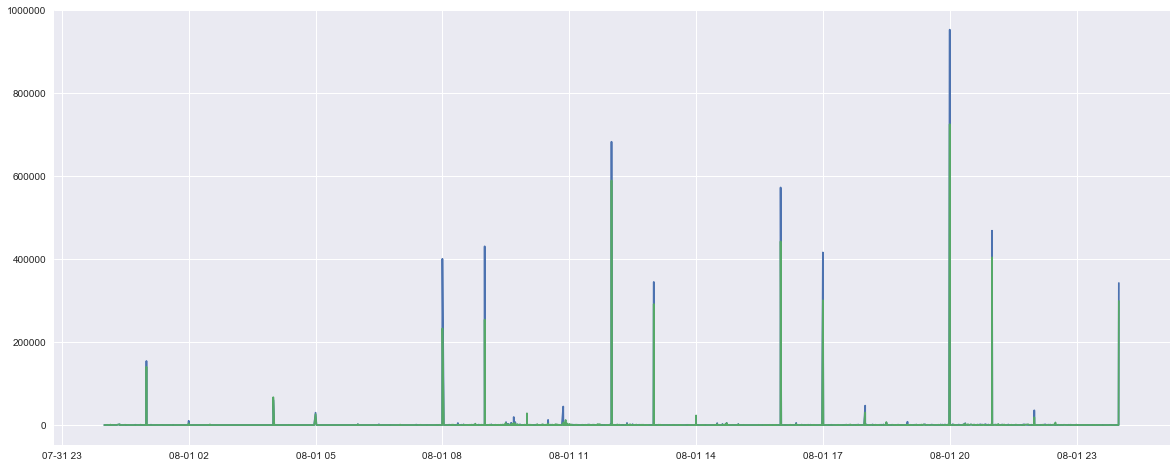

In [11]:
plt.figure(figsize = (20,8))
date = matplotlib.dates.datestr2num(a['dt'].tolist())
#plt.plot_date(date,a['busyness'],'-')
plt.plot_date(date,a['entries_change'],'-')
plt.plot_date(date,a['exits_change'],'-')

In [12]:
df_0801['busyness'] = df_0801['entries_change']+df_0801['exits_change']

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
df_0801.sort_values('busyness', ascending = False).head()

,date,time,disc,entries,exits,location,datetime,dt,entries_change,exits_change,Booth,Remote,busyness,Station,Line Name,Division
660891,08-01-13,10:51:31,REGULAR,44584,4414,PTH05 R543 00-04-00,08-01-13 10:51:31,2013-08-01 10:51:31,44581.0,4396.0,PTH05,R543,48977.0,EXCHANGE PLACE,1,PTH
753118,08-01-13,20:00:00,REGULAR,13560102,47368961,N063A R011 00-00-00,08-01-13 20:00:00,2013-08-01 20:00:00,95.0,3951.0,N063A,R011,4046.0,42 ST-PA BUS TE,ACENQRS1237,IND
754898,08-01-13,20:00:00,REGULAR,20085677,30908428,N063A R011 00-00-01,08-01-13 20:00:00,2013-08-01 20:00:00,155.0,3721.0,N063A,R011,3876.0,42 ST-PA BUS TE,ACENQRS1237,IND
449452,08-02-13,00:00:00,REGULAR,360021,41814358,N507 R023 00-00-00,08-02-13 00:00:00,2013-08-02 00:00:00,33.0,3842.0,N507,R023,3875.0,34 ST-HERALD SQ,BDFMNQR,IND
175007,08-01-13,20:00:00,REGULAR,239224,2398690,R249 R179 01-00-09,08-01-13 20:00:00,2013-08-01 20:00:00,381.0,3145.0,R249,R179,3526.0,86 ST,456,IRT


In [17]:
#total number of entries on 08012013
print ('Total number of entries on August 1, 2013: ' ,int(df_0801['entries_change'].sum()))

Total number of entries on August 1, 2013:  5550594


In [19]:
#total number of exits on 08012013
print ('Total number of entries on August 1, 2013: ' ,int(df_0801['exits_change'].sum()))

Total number of entries on August 1, 2013:  4353322


##### Q1 Answer
Total number of entries on August 1, 2013:  5550594

Total number of entries on August 1, 2013:  4353322

### Q2. What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?

In [20]:
df_0801.groupby('Station').sum().reset_index().sort_values('busyness',ascending = False).head()

,Station,entries,exits,entries_change,exits_change,busyness
67,34 ST-PENN STA,4416246177,3000086280,175313.0,156138.0,331451.0
72,42 ST-GRD CNTRL,3442891478,2366714677,165003.0,151252.0,316255.0
66,34 ST-HERALD SQ,2168221023,2173729931,122548.0,114529.0,237077.0
74,42 ST-TIMES SQ,1253148276,2904504784,105023.0,98255.0,203278.0
18,14 ST-UNION SQ,2588577468,1299808617,104395.0,92719.0,197114.0


In [21]:
df_0801.groupby('location').sum().reset_index().sort_values('busyness',ascending = False).head()

,location,entries,exits,entries_change,exits_change,busyness
2523,PTH05 R543 00-04-00,267600,26547,44769.0,4419.0,49188.0
1149,N063A R011 00-00-00,94916009,331548586,1882.0,9963.0,11845.0
3499,R249 R179 01-00-09,1433030,14367900,964.0,10559.0,11523.0
3391,R240 R047 00-00-00,26008923,63119519,3831.0,7309.0,11140.0
1251,N083 R138 01-00-00,24999744,54105765,2107.0,8461.0,10568.0


##### Q2 Answer
The busiest station is 34 ST-PENN STA with 175313 entries and 156138 exits.

The busiest turnstile is PTH05 R543 00-04-00 with 44769 entries and 4419 exits -- a little strange as the entries counts and exits counts differ that much

### Q3.  What were the busiest and least-busy stations in the system over all of July 2013?


In [22]:
july = df_merge[(df_merge['dt']<='2013-08-01 00:00:00') & (df_merge['dt']> '2013-07-01 00:00:00')]

In [23]:
july.shape

(953741, 16)

In [24]:
#remove outlier - replace with 0
outlier_1 = july[july['entries_change']<0].index.tolist()
outlier_2 = july[july['exits_change']<0].index.tolist()
outlier_3 = july[july['entries_change']>50000].index.tolist()
outlier_4 = july[july['exits_change']>50000].index.tolist()
outliers = outlier_1+outlier_2+outlier_3+outlier_4

In [25]:
july.fillna(0)
july.loc[outliers,['entries_change','exits_change']] = 0

//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
a = july.groupby('dt').sum().reset_index()

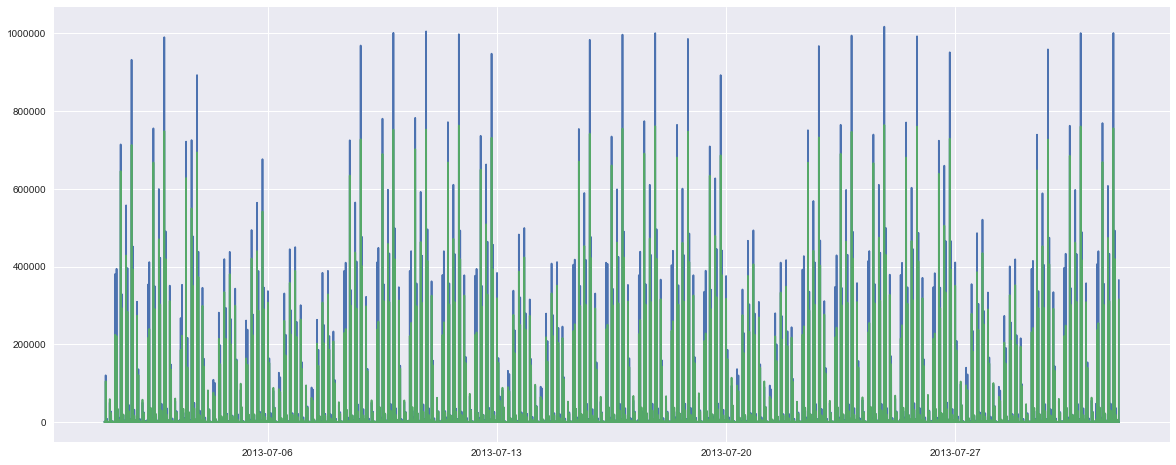

In [27]:
plt.figure(figsize = (20,8))
date = matplotlib.dates.datestr2num(a['dt'].tolist())
#plt.plot_date(date,a['busyness'],'-')
plt.plot_date(date,a['entries_change'],'-')
plt.plot_date(date,a['exits_change'],'-')

In [28]:
july['busyness'] = july['entries_change']+july['exits_change']

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
july.groupby('Station').sum().reset_index().sort_values('busyness',ascending = False).head()

,Station,entries,exits,entries_change,exits_change,busyness
67,34 ST-PENN STA,119803187490,82887910280,4578140.0,4018179.0,8596319.0
72,42 ST-GRD CNTRL,88097558369,66455828247,3845080.0,3609752.0,7454832.0
66,34 ST-HERALD SQ,63089980345,63269142524,3212704.0,2985543.0,6198247.0
74,42 ST-TIMES SQ,40099107983,94945541600,2839397.0,2752965.0,5592362.0
18,14 ST-UNION SQ,85643821643,35367177428,2899685.0,2649804.0,5549489.0


In [31]:
july.groupby('Station').sum().reset_index().sort_values('busyness',ascending = True).head()

,Station,entries,exits,entries_change,exits_change,busyness
121,AQUEDUCT TRACK,10710597337,3560668681,117.0,152.0,269.0
161,BROAD CHANNEL,311966259,107856414,5776.0,2670.0,8446.0
312,ORCHARD BEACH,92760348,5216670,16260.0,1002.0,17262.0
356,TOMPKINSVILLE,1692849459,514313635,18363.0,1.0,18364.0
142,BEACH 44 ST,430955124,578560672,14226.0,16644.0,30870.0


##### Q3 Answer
The busiest station in July is 34 ST-PENN STA with 4578140 entries and 4018179 exits. 

The least busy station is AQUEDUCT TRACK with 117 entries and 152 exits.

### Q4.  Which station had the highest average number of entries between midnight & 4am on Fridays in July 2013?


In [32]:
# Get Week of Day data
import datetime
import calendar
from datetime import datetime
f = '%Y-%m-%d %H:%M:%S'
df_merge['weekday'] = df_merge['dt'].apply(lambda x: calendar.day_name[datetime.strptime(x,f).weekday()])
df_merge.head()

,date,time,disc,entries,exits,location,datetime,dt,entries_change,exits_change,Booth,Remote,busyness,Station,Line Name,Division,weekday
0,06-29-13,00:00:00,REGULAR,3775585,4786056,C008 R099 00-00-00,06-29-13 00:00:00,2013-06-29 00:00:00,NaN,NaN,C008,R099,NaN,DEKALB AVE,BDNQR,BMT,Saturday
1,06-29-13,04:00:00,REGULAR,3775645,4786184,C008 R099 00-00-00,06-29-13 04:00:00,2013-06-29 04:00:00,60.0,128.0,C008,R099,188.0,DEKALB AVE,BDNQR,BMT,Saturday
2,06-29-13,04:00:00,RECOVR AUD,3775645,4786184,C008 R099 00-00-00,06-29-13 04:00:00,2013-06-29 04:00:00,0.0,0.0,C008,R099,0.0,DEKALB AVE,BDNQR,BMT,Saturday
3,06-29-13,08:00:00,REGULAR,3775689,4786264,C008 R099 00-00-00,06-29-13 08:00:00,2013-06-29 08:00:00,44.0,80.0,C008,R099,124.0,DEKALB AVE,BDNQR,BMT,Saturday
4,06-29-13,09:15:50,DOOR OPEN,3775722,4786301,C008 R099 00-00-00,06-29-13 09:15:50,2013-06-29 09:15:50,33.0,37.0,C008,R099,70.0,DEKALB AVE,BDNQR,BMT,Saturday


In [33]:
#GET all July Friday data
july_fri = df_merge[(df_merge['weekday'] == 'Friday') \
                    & ((df_merge['time']<= '04:00:00') & (df_merge['time']>'00:00:00'))\
                    &(df_merge['date']<'08-01-13') \
                    & (df_merge['date']>='07-01-13')]

In [34]:
#remove outlier - replace with 0
outlier_1 = july_fri[july_fri['entries_change']<0].index.tolist()
outlier_2 = july_fri[july_fri['exits_change']<0].index.tolist()
outlier_3 = july_fri[july_fri['entries_change']>50000].index.tolist()
outlier_4 = july_fri[july_fri['exits_change']>50000].index.tolist()
outliers = outlier_1+outlier_2+outlier_3+outlier_4
outliers

[]

In [36]:
july_fri.groupby('Station').mean().reset_index().sort_values('entries_change', ascending = False).head()

,Station,entries,exits,entries_change,exits_change,busyness
366,W 4 ST-WASH SQ,1.322984e+07,5.545697e+06,436.171053,204.473684,640.644737
18,14 ST-UNION SQ,9.977501e+06,4.182393e+06,381.853659,160.993902,542.847561
109,8 AVE,8.136542e+06,5.105369e+06,368.388889,177.750000,546.138889
379,YORK ST,8.108152e+06,7.698871e+06,352.333333,193.083333,545.416667
123,ASTOR PLACE,4.385038e+06,1.780139e+06,216.291667,113.458333,329.750000


##### Q5 Answer
W 4 ST-WASH SQ station had the highest average number of entries,436, between midnight & 4am on Fridays in July 2013